<a href="https://colab.research.google.com/github/Sabeerawa05/Datasets-Practices/blob/main/poverty_pred_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import cv2
import os
from imutils import paths
import random
import h5py
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.utils import to_categorical
import progressbar
import matplotlib.pyplot as plt

In [ ]:
class HDF5DatasetWriter:
    def __init__(self, dims, outputPath, dataKey="images",bufSize=1000):
        # check to see if the output path exists, and if so, raise
        # an exception
        if os.path.exists(outputPath):
            raise ValueError("The supplied ‘outputPath‘ already "
                             "exists and cannot be overwritten. Manually delete "
                             "the file before continuing.", outputPath)

        # open the HDF5 database for writing and create two datasets:
        # one to store the images/features and another to store the
        # class labels
        self.db = h5py.File(outputPath, "w")
        self.data = self.db.create_dataset(dataKey, dims,
                                           dtype="float")
        self.labels = self.db.create_dataset("labels", (dims[0], 4),
                                             dtype="float")

        # store the buffer size, then initialize the buffer itself
        # along with the index into the datasets
        self.bufSize = bufSize
        self.buffer = {"data": [], "labels": []}
        self.idx = 0

    def add(self, rows, labels):
        # add the rows and labels to the buffer
        self.buffer["data"].extend(rows)
        self.buffer["labels"].extend(labels)

        # check to see if the buffer needs to be flushed to disk
        if len(self.buffer["data"]) >= self.bufSize:
            self.flush()

    def flush(self):
        # write the buffers to disk then reset the buffer
        i = self.idx + len(self.buffer["data"])
        self.data[self.idx:i] = self.buffer["data"]
        self.labels[self.idx:i] = self.buffer["labels"]
        self.idx = i
        self.buffer = {"data": [], "labels": []}

    def storeClassLabels(self, classLabels):
        # create a dataset to store the actual class label names,
        # then store the class labels
        dt = h5py.special_dtype(vlen=str)
        labelSet = self.db.create_dataset("label_names",
                                          (len(classLabels),), dtype=dt)
        labelSet[:] = classLabels

    def close(self):
        # check to see if there are any other entries in the buffer
        # that need to be flushed to disk
        if len(self.buffer["data"]) > 0:
            self.flush()

        # close the dataset
        self.db.close()

In [ ]:
#data_path = '/content/drive/MyDrive/archive'

In [ ]:
data_path = 'satelitte_images'
train_hdf5 = 'satelitte_images/hdf5/train.hdf5'
val_hdf5 =  'satelitte_images/hdf5/val.hdf5'
test_hdf5 =  'satelitte_images/hdf5/test.hdf5'

In [ ]:
# reading all images in the dataset
imagePaths = list(paths.list_images(data_path))

In [ ]:
imagePaths[:5]

['satelitte_images\\ethiopia_archive\\images\\10.001614493498009_38.21928274979602_10.0165864149_38.2492265926.png',
 'satelitte_images\\ethiopia_archive\\images\\10.006878190821991_37.647636949694025_9.99190626942_37.6925527139.png',
 'satelitte_images\\ethiopia_archive\\images\\10.009539116998008_39.16824952909403_10.0245110384_39.2131652933.png',
 'satelitte_images\\ethiopia_archive\\images\\10.009539116998008_39.18322145049602_10.0245110384_39.2131652933.png',
 'satelitte_images\\ethiopia_archive\\images\\10.009539116998008_39.2131652933_10.0245110384_39.2131652933.png']

In [ ]:
len(imagePaths)

56160

In [ ]:
# shufflimg all images in dataset for reproducibilty
random.seed(42)
random.shuffle(imagePaths)

In [ ]:
imagePaths[:5]

['satelitte_images\\ethiopia_archive\\images\\8.103335065686016_38.193701130798004_8.13327890849_38.2086730522.png',
 'satelitte_images\\malawi_archive\\images\\-10.739254078598007_33.55225392140199_-10.754226_33.537282.png',
 'satelitte_images\\malawi_archive\\images\\-15.781865235794024_35.142495764205975_-15.826781_35.09758.png',
 'satelitte_images\\malawi_archive\\images\\-15.735151842803985_35.136095078598004_-15.705208_35.151067.png',
 'satelitte_images\\ethiopia_archive\\images\\ethiopia_Images\\8.563866629893985_39.223355202794025_8.53392278709_39.268270967.png']

In [ ]:
# extract label (category) of images from path
imageLabels = [p.split(os.path.sep)[1] for p in imagePaths]

In [ ]:
len(imageLabels)

56160

In [ ]:

le = LabelEncoder()
imageLabels = le.fit_transform(imageLabels)

In [ ]:
classNames = [pt.split(os.path.sep)[1] for pt in imagePaths]
classNames = [str(x) for x in np.unique(classNames)]

In [ ]:
classNames

['Mali_archive', 'ethiopia_archive', 'malawi_archive', 'nigeria_archive']

In [ ]:
np.unique(imageLabels)

array([0, 1, 2, 3], dtype=int64)

In [ ]:
# one-hot encode of image label
imageLabels = to_categorical(imageLabels, len(classNames))

In [ ]:
imageLabels

array([[0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

In [ ]:
# perform stratified sampling from the training set to build the
 # testing split from the training data
split = train_test_split(imagePaths, imageLabels,
                         test_size=0.10, stratify=imageLabels,  random_state=42)

(trainPaths, testPaths, trainLabels, testLabels) = split

# perform another stratified sampling, this time to build the
# validation data
split = train_test_split(trainPaths, trainLabels,
                         test_size=0.15, stratify=trainLabels,random_state=42)

(trainPaths, valPaths, trainLabels, valLabels) = split

In [ ]:
# construct a list pairing the training, validation, and testing
# image paths along with their corresponding labels and output HDF5
# files
datasets = [("train", trainPaths, trainLabels, train_hdf5),
            ("val", valPaths, valLabels, val_hdf5),
            ("test", testPaths, testLabels, test_hdf5)]

In [ ]:
# loop over the dataset tuples
for (dType, paths, labels, outputPath) in datasets:
    # create HDF5 writer
    print("[INFO] building {}...".format(outputPath))
    writer = HDF5DatasetWriter((len(paths), 256, 256, 3), outputPath)

    # initialize the progress bar
    widgets = ["Building Dataset: ", progressbar.Percentage(), " ",
               progressbar.Bar(), " ", progressbar.ETA()]
    pbar = progressbar.ProgressBar(maxval=len(paths),
                                   widgets=widgets).start()

    # loop over the image paths
    for (i, (path, label)) in enumerate(zip(paths, labels)):
        # load the image and process it
        image = cv2.imread(path)
        image = image.astype('float')/255.0

        # add the image and label # to the HDF5 dataset
        writer.add([image], [label])
        pbar.update(i)

    # close the HDF5 writer
    pbar.finish()
    writer.close()


[INFO] building satelitte_images/hdf5/train.hdf5...


Building Dataset: 100% |########################################| Time: 0:31:07


[INFO] building satelitte_images/hdf5/val.hdf5...


Building Dataset: 100% |########################################| Time: 0:04:34


[INFO] building satelitte_images/hdf5/test.hdf5...


Building Dataset: 100% |########################################| Time: 0:03:15


In [ ]:
def read_hdf5(dir):
    db = h5py.File(dir, mode='r')

    return db

In [ ]:
train_data = read_hdf5(train_hdf5)

In [ ]:
list(train_data.keys())

['images', 'labels']

In [ ]:
train_data['images'].shape

(42962, 256, 256, 3)

In [ ]:
train_data['labels'].shape

(42962, 4)

In [ ]:
val_data = read_hdf5(val_hdf5)

In [ ]:
test_data = read_hdf5(test_hdf5)

In [ ]:
train_data['images'][0:32].shape


(32, 256, 256, 3)

In [ ]:
## generate batches of image, label pair for training as a sequences/generator
class HDF5DatasetGenerator:

    def __init__(self, dbPath, batchSize):

        # store the batch size, preprocessors, and data augmentor,
        # whether or not the labels should be binarized, along with
        # the total number of classes
        self.batchSize = batchSize


        # open the HDF5 database for reading and determine the total
        # number of entries in the database
        self.db = h5py.File(dbPath, mode='r')
        self.numImages = self.db["labels"].shape[0]


    def generator(self, passes=np.inf):
        # initialize the epoch count
        epochs = 0

        # keep looping infinitely -- the model will stop once we have
        # reach the desired number of epochs
        while epochs < passes:
            # loop over the HDF5 dataset
            for i in np.arange(0, self.numImages, self.batchSize):
                # extract the images and labels from the HDF dataset
                images = self.db["images"][i: i + self.batchSize]
                labels = self.db["labels"][i: i + self.batchSize]

                # yield a tuple of images and labels
                yield (images, labels)

    def close(self):
        # close the database
        self.db.close()

In [ ]:
# initialize the training and validation dataset generators
trainGen = HDF5DatasetGenerator(train_hdf5, 8)
valGen = HDF5DatasetGenerator(val_hdf5, 8)
testGen = HDF5DatasetGenerator(test_hdf5, 8)

## CNN MODEL

In [ ]:
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras import backend as K
from keras.layers import Activation
from keras.models import load_model
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.optimizers import SGD
from keras.optimizers import Adam


class CNNModel:

    def build(width, height, depth, classes):

        inputShape = (height,width, depth)
        chanDim = -1

        if(K.image_data_format()== 'channels_first'):
            inputShape = (depth, height, width)
            chanDim = 1

        #first layer
        model = Sequential()
        model.add(Conv2D(32, (3,3), input_shape = inputShape ,padding='same'))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        #second layer
        model.add(Conv2D(32, (3,3), padding='same' ))
        model.add(Activation('relu'))
        model.add(BatchNormalization(axis=chanDim))
        #regularization
        model.add(MaxPooling2D(pool_size = (2,2), strides=(2,2)))
        model.add(Dropout(0.25))

        #thirt layer
        model.add(Conv2D(64, (3,3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization(axis=chanDim))
        #fourth layer
        model.add(Conv2D(64, (3,3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2,2), strides= (2,2)))
        model.add(Dropout(0.25))

        #fifth layer
        model.add(Conv2D(128, (3,3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization(axis=chanDim))
        #sixth layer
        model.add(Conv2D(128, (3,3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2,2), strides= (2,2)))
        model.add(Dropout(0.25))

        #seventh layer
        model.add(Conv2D(256, (3,3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization(axis=chanDim))
        #eighth layer
        model.add(Conv2D(256, (3,3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2,2), strides= (2,2)))
        model.add(Dropout(0.25))




        #classification layer
        model.add(Flatten())
        model.add(Dense(1024))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dense(1024))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))

        model.add(Dense(classes))
        model.add(Activation('softmax'))

        return model

In [ ]:
print("[INFO] compiling model...")
epoch = 200
opt = Adam(lr=1e-4, decay=1e-4/epoch)
cnn_model = CNNModel.build(width=256, height=256, depth=3,
classes=len(classNames))
cnn_model.compile(loss="categorical_crossentropy", optimizer=opt,
metrics=["accuracy"])

[INFO] compiling model...


In [ ]:
es = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)]

In [ ]:
# train the network
print("[INFO] training network...")
CNNHist = cnn_model.fit(x = trainGen.generator(),
                        validation_data=valGen.generator(),
                        steps_per_epoch=trainGen.numImages // 8,
                        validation_steps=valGen.numImages // 8,
                        batch_size=8,
                        epochs=epoch, callbacks=es, verbose=1)

[INFO] training network...
Epoch 1/200
5370/5370 [==============================] - 897s 166ms/step - loss: 1.4099 - accuracy: 0.4452 - val_loss: 1.0946 - val_accuracy: 0.5424
Epoch 2/200
5370/5370 [==============================] - 897s 167ms/step - loss: 1.2169 - accuracy: 0.4882 - val_loss: 1.0971 - val_accuracy: 0.5491
Epoch 3/200
5370/5370 [==============================] - 896s 167ms/step - loss: 1.0568 - accuracy: 0.5724 - val_loss: 0.8810 - val_accuracy: 0.6364
Epoch 4/200
5370/5370 [==============================] - 909s 169ms/step - loss: 0.9535 - accuracy: 0.6185 - val_loss: 0.7990 - val_accuracy: 0.6810
Epoch 5/200
5370/5370 [==============================] - 918s 171ms/step - loss: 0.8467 - accuracy: 0.6641 - val_loss: 1.1237 - val_accuracy: 0.5647
Epoch 6/200
5370/5370 [==============================] - 921s 172ms/step - loss: 0.7727 - accuracy: 0.6956 - val_loss: 0.9280 - val_accuracy: 0.6472
Epoch 7/200
5370/5370 [==============================] - 915s 170ms/step - loss

In [ ]:
# saving model
cnn_model.save('satelitte_models/cnn_model_satelitte.h5')

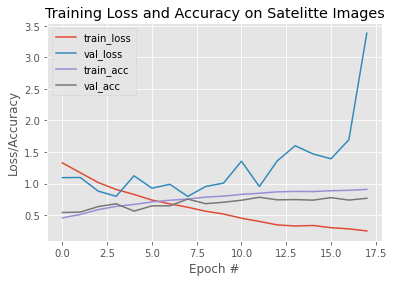

In [ ]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(CNNHist.history["loss"], label="train_loss")
plt.plot(CNNHist.history["val_loss"], label="val_loss")
plt.plot(CNNHist.history["accuracy"], label="train_acc")
plt.plot(CNNHist.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Satelitte Images")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [ ]:
testGen.numImages

5616

In [ ]:
num_pred = (testGen.numImages // 8) * 8
num_pred

5616

In [ ]:
# evaluate the network
print("[INFO] evaluating network...")
num_pred = (testGen.numImages // 8) * 8
predictions = cnn_model.predict(testGen.generator(passes=1),
                                      steps=testGen.numImages // 8)
y_pred = predictions.argmax(axis=-1)
y_true = test_data['labels'][...].argmax(axis=-1)[:num_pred]
print(classification_report(y_true, y_pred,
                            target_names=classNames))
#predictions = model.predict(testX, batch_size=32)
#print(classification_report(testY.argmax(axis=1),
                            #predictions.argmax(axis=1), target_names=classNames))

[INFO] evaluating network...
                  precision    recall  f1-score   support

    Mali_archive       0.83      0.64      0.72      1475
ethiopia_archive       0.75      0.83      0.79      1717
  malawi_archive       0.74      0.82      0.78      1270
 nigeria_archive       0.70      0.72      0.71      1154

        accuracy                           0.75      5616
       macro avg       0.76      0.75      0.75      5616
    weighted avg       0.76      0.75      0.75      5616

